In [50]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [51]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

In [52]:
import git
git = git.Git("../../../sonarqube/") 

# Goal

In this notebook we will analyse the jobs and builds associated to the tags via the commit difference with the previous tag. We will investigate what jobs and builds will be left out from the association and implement algorithms to refine our selection of jobs based on PRs and FixVersions

### Import builds and jobs

In [53]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)

In [54]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
0,241946101,241946099,2017-06-12 09:21:03+00:00,2017-06-12 09:13:51.063000+00:00,2017-06-12 09:21:43+00:00,25614.1,canceled,2018-06-02 14:51:19.734000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
1,241946103,241946099,2017-06-12 09:22:43+00:00,2017-06-12 09:13:51.107000+00:00,2017-06-12 09:21:43+00:00,25614.2,canceled,2018-06-02 14:51:19.764000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
2,241952024,241952022,2017-06-12 09:36:43+00:00,2017-06-12 09:32:52.227000+00:00,2017-06-12 09:37:23+00:00,25615.1,canceled,2018-06-02 14:51:25.661000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
3,241952025,241952022,NaT,2017-06-12 09:32:52.237000+00:00,2017-06-12 09:37:24+00:00,25615.2,canceled,2018-06-02 14:51:25.669000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
4,241952045,241952044,2017-06-12 09:42:16+00:00,2017-06-12 09:32:59.994000+00:00,2017-06-12 09:53:48+00:00,25616.1,passed,2018-06-02 14:51:26.125000+00:00,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,70183633,SONAR-9304 Add comments to make tests clearer,refs/pull/2104/merge,https://github.com/SonarSource/sonarqube/pull/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136978,315411337,315411335,2017-12-12 15:23:15+00:00,2017-12-12 15:22:41.091000+00:00,2017-12-12 15:26:39+00:00,34811.2,passed,2018-06-03 16:57:36.971000+00:00,abd0650045b3fcc95ac8459a6fc2450a1bd889c0,93642638,SONAR-10134 Fix ITs on quality gates by settin...,refs/pull/2866/merge,https://github.com/SonarSource/sonarqube/pull/...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136980,315421140,315421138,2017-12-12 15:43:26+00:00,2017-12-12 15:42:34.682000+00:00,2017-12-12 15:44:25+00:00,34812.2,passed,2018-06-03 16:57:47.778000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136981,315421147,315421146,2017-12-12 15:43:25+00:00,2017-12-12 15:42:40.583000+00:00,2017-12-12 16:01:05+00:00,34813.1,passed,2018-06-03 16:57:47.837000+00:00,a5005e0ca38a67e7d70c255154990ed10be31020,93645838,SONAR-10187 Provide more options to populate e...,refs/pull/2895/merge,https://github.com/SonarSource/sonarqube/pull/...


### Pull Requests commits

In [55]:
pr_commits = pd.read_csv(f"{csv_folder}/pr_commits.csv", index_col=0)

### Import all tag comparisons dataset

In [56]:
compare_tags = pd.read_csv(f"{csv_folder}/compare_tags_sha.csv", index_col=0)
compare_tags.head(2)

,from_tag,from_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_date
0,8.4.2.36762,2020-08-27 14:11:31,2de1f343e3dbd9e88007b42e475512677c04eb8a,a0d372f704998d38856c26e28662fd7de062f873,0,4,8.4.1.35646,2020-07-14 08:13:18
1,8.4.0.35506,2020-07-03 07:09:27,74b4533439f380827d68e8c01667eeaecad89fc7,a0d372f704998d38856c26e28662fd7de062f873,6,0,8.4.1.35646,2020-07-14 08:13:18


### Import tags

In [57]:
alltags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
alltags.Date = pd.to_datetime(alltags.Date)
alltags.actual_release_date = pd.to_datetime(alltags.actual_release_date)
alltags["month"] = alltags.Date.dt.month
alltags["year"] = alltags.Date.dt.year
alltags.rename(columns={"Date":"release_date"}, inplace=True)
tags = alltags.tail(-1)
tags.head()

,actual_release_date,Tag,Sha,release_date,month,year,major_version,jira_version
1,NaT,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaT,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaT,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2
5,2015-11-26,5.2,f045be98be3ba032b6b19d71574038eeeb91803b,2015-11-02 08:56:19,11,2015,5,5.2


### Filter the ones after the project started using TravisCI

In [58]:
tags = tags[tags.release_date > "2015-03-10"]

In [59]:
tags.Tag.nunique()

56

### Import tag comparison pairs

In [60]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
#removing first 3 tags
tags_comparison = tags_comparison.tail(-3)
tags_comparison.head()

,from_author_date,to_author_date,ahead_by,behind_by,from_sha,to_sha,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days,to_tag,from_tag
3,2015-07-27 08:03:21,2015-11-02 08:56:19,2853,0,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,f045be98be3ba032b6b19d71574038eeeb91803b,2853,98 days 00:52:58,98.036782,2015-07-27 10:03:21,2015-11-02 09:56:19,97 days 23:52:58,97.995116,5.2,5.1.2
4,2015-11-02 08:56:19,2016-01-08 10:09:15,561,0,f045be98be3ba032b6b19d71574038eeeb91803b,8db783e62b266eeb0d0b10dc050a7ca50e96c5d1,561,67 days 01:12:56,67.050648,2015-11-02 09:56:19,2016-01-08 11:09:15,67 days 01:12:56,67.050648,5.3,5.2
5,2016-01-08 10:09:15,2016-03-08 15:48:19,438,0,8db783e62b266eeb0d0b10dc050a7ca50e96c5d1,7b02df9be3cd9448699b5857586e1c6e2b28c007,438,60 days 05:39:04,60.235463,2016-01-08 11:09:15,2016-03-08 16:48:19,60 days 05:39:04,60.235463,5.4,5.3
6,2016-03-08 15:48:19,2016-05-02 14:09:29,725,0,7b02df9be3cd9448699b5857586e1c6e2b28c007,5773a4aab0ef6c0de79d3038e82f8a051049d6d0,725,54 days 22:21:10,54.931366,2016-03-08 16:48:19,2016-05-02 16:09:29,54 days 23:21:10,54.973032,5.5,5.4
7,2016-05-02 14:09:29,2016-06-01 11:59:09,349,0,5773a4aab0ef6c0de79d3038e82f8a051049d6d0,074f3d1169f9688d15af4aff67e7e672cbeed782,349,29 days 21:49:40,29.909491,2016-05-02 16:09:29,2016-06-01 13:59:09,29 days 21:49:40,29.909491,5.6,5.5


### Import issues

In [61]:
issues = pd.read_csv(f"{csv_folder}/issues_community.csv", index_col=0)
for date_field in ["created", "duedate", "lastViewed", "resolutiondate", "updated"]:
    issues[date_field] = pd.to_datetime(issues[date_field], errors="coerce")
issues = issues[issues.created > '2015-03-17 15:04:32+0000']
issues.head()

,updated,environment,creator,issue_id,reporter,issuetype_name,issue_key,assignee,votes,created,project,resolutiondate,status_id,summary,reporter_name,resolution_name,lastViewed,issuetype_id,edition,duedate,status_name,votes_votes,description,priority_id,priority_name,status,assignee_name,creator_name,created_month,created_year
0,2020-09-29 08:54:53+00:00,NaN,Julien Lancelot,97898,Julien Lancelot,Task,SONAR-13913,NaN,0,2020-09-29 08:54:53+00:00,SONAR,NaT,1,Remove table clean up used in Integration Tests,julien.lancelot,NaN,NaT,3,Community,NaT,Open,0,- Remove org.sonar.server.platform.BackendClea...,3,Major,Open,NaN,julien.lancelot,9,2020
1,2020-09-28 10:18:24+00:00,NaN,Malena Ebert,97868,Malena Ebert,Task,SONAR-13912,Malena Ebert,0,2020-09-28 10:14:16+00:00,SONAR,NaT,1,Add OWASP Dependency Check task to Cirrus CI,malena.ebert,NaN,NaT,3,Community,NaT,Open,0,The goal of this task is to detect vulnerabili...,3,Major,Open,malena.ebert,malena.ebert,9,2020
3,2020-09-28 15:38:40+00:00,NaN,Jeremy Davis,97858,Jeremy Davis,New Feature,SONAR-13909,Julien Lancelot,0,2020-09-28 09:20:49+00:00,SONAR,NaT,10002,C# and VB.NET analysis updates,jeremy.davis,NaN,NaT,2,Community,2020-10-05 00:00:00+00:00,In Review,0,The C# analysis now improves complexity rules ...,3,Major,In Review,julien.lancelot,jeremy.davis,9,2020
4,2020-09-28 20:02:41+00:00,NaN,Jeremy Davis,97855,Jeremy Davis,Improvement,SONAR-13907,Julien Lancelot,0,2020-09-28 09:00:01+00:00,SONAR,NaT,10002,JavaScript/TypeScript analysis updates,jeremy.davis,NaN,NaT,4,Community,2020-10-05 00:00:00+00:00,In Review,0,The changes are:\r\n* a new rule to detect XXE...,3,Major,In Review,julien.lancelot,jeremy.davis,9,2020
5,2020-09-24 12:57:08+00:00,NaN,Mathieu Cutivel,97813,Mathieu Cutivel,Improvement,SONAR-13906,Mathieu Cutivel,0,2020-09-24 12:57:00+00:00,SONAR,NaT,3,Prevent ALM binding configuration modal from c...,mathieu.cutivel,NaN,NaT,4,Community,2020-10-01 00:00:00+00:00,In Progress,0,When clicking outside of the ALM configuration...,3,Major,In Progress,mathieu.cutivel,mathieu.cutivel,9,2020


In [62]:
issues.shape

(4478, 30)

### Import issue versions

In [63]:
versions = pd.read_csv(f"{csv_folder}/issues_versions.csv", index_col=0)
versions.head()

,issue_id,version_name,version_id
0,97777,8.4.2,16404
1,97773,8.4.2,16404
2,97525,8.4.2,16404
3,97521,8.4,15833
4,97347,8.4.2,16404


### Import issue fixversions

In [64]:
fix_versions = pd.read_csv(f"{csv_folder}/issues_fixversions.csv", index_col=0)
fix_versions.head()

,issue_id,fixVersion_name,fixVersion_id
0,97864,8.5,16342
1,97858,8.5,16342
2,97855,8.5,16342
3,97786,8.6,16435
4,97773,8.5,16342


### Import Pull request data

In [65]:
prs = pd.read_csv(f"{csv_folder}/prs.csv", index_col=0)
prs.created_at = pd.to_datetime(prs.created_at)
prs.closed_at = pd.to_datetime(prs.closed_at)

In [66]:
prs

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,2015,SONAR-9122 prevent setting a project as private,2017-05-03 12:26:16+00:00,2017-05-04 09:19:56+00:00,closed,True,e10f04d5b4055e2813ac01a811b325a414797c4e,b10cb50ec7c26a85dd549de6633e60705994bd66,master,13bb5a131e0fa2c20f041d4e8c79e847fc601348,feature/stas/lock-private-projects
1,2008,Upgrade scanner in performance tests,2017-05-02 19:17:44+00:00,2017-05-04 11:50:06+00:00,closed,False,492bb4ff488ee992a3708622ca9a6be88ee7f11a,7b2958e443c4c629f3e35aba7182d7cb524b250b,master,9a90c2f7097fab8fe94681b1e7ea09294a308314,feature/sb/sonar-runner-in-its
2,2026,SQ 6.4 web hardening 5,2017-05-04 15:17:16+00:00,2017-05-09 09:14:37+00:00,closed,True,ab64e97deecaf047d85debdd1ba669e1d4071d51,87d60ccc748d84f55f7c102b6ec6d489215eef8f,master,368935160f780caf8a9b7ff250606e84c68c50cb,feature/greg/6.4_web_hardening_5
3,2046,Hardening Wednesday,2017-05-10 11:54:28+00:00,2017-05-11 08:56:18+00:00,closed,False,041ee672ade0c77d75db0ca379bad255936d9730,7f939f50b63f7c6ac7aab6d8fbb71a06193df0be,master,285e16edf389aa34db2bc2f0ce99a2e3042f3f32,feature/tb/hardening-wednesday
4,2021,SONAR-6135 Upgrade MySQL driver to 5.1.42,2017-05-04 07:42:23+00:00,2017-05-04 12:52:45+00:00,closed,True,5e1fdd17e3147180e3a4273705835e2fc393ae20,6d18fa56e8782e022169738587750dfe59b4015a,master,da23d42a0af4db59d7aeac71dd51f659b43f763b,feature/eh/SONAR-6135
...,...,...,...,...,...,...,...,...,...,...,...
3244,610,SONAR-6919 Enforce some mandatory web service ...,2015-11-02 16:09:25+00:00,2015-11-05 14:52:07+00:00,closed,False,5da330ecc08721aca649a4a401e89149d267b42d,526e3b9053582e4921d705c35a4b24d3cd9d0d60,master,526e3b9053582e4921d705c35a4b24d3cd9d0d60,feature/ws_enforce_mandatory_fields
3245,620,SONAR-6922 Initial version of report viewer,2015-11-06 10:13:57+00:00,2015-11-09 07:40:54+00:00,closed,True,15f6f81f1ff387f387bca18342301a2e88877060,7567526369d1082a8023623c016b970cac314c64,master,eb5fd4fe77eb1b82b3aa5e1c3474d85ac39ee9ce,feature/report_viewer
3246,639,SONAR-7027 Add developer concept in CE,2015-11-18 14:03:35+00:00,2015-11-19 13:48:15+00:00,closed,True,a8ce34fd965d2ea0e212b3576666ee594459f8c5,30e7baee5a1785168c2e2c2bcea73ae1a78087da,master,240cf9f64ff0d7aa1e94f4fdeeb449f48141bcb0,feature/introduce_dev_in_ce
3247,602,SONAR-6834 Purge CE_ACTIVITY when deleting a p...,2015-10-27 10:31:24+00:00,2015-10-27 11:07:27+00:00,closed,False,68c6fe12c4df2678e1a0ca8d60afb300b0faba50,19350f7eb06f0f46674ad394e0919edbae2b2a2a,branch-5.2,8d809c371e9b00c1886b1f7e83d8699e546bdb0e,feature/delete_ce_activity_when_del_project


### Commitmessages

def get_commit_message(sha):
    return git.log("--pretty=oneline","-n 1",sha).replace(f"{sha} ", "")

tags_comparison_commits["commit_message"] = tags_comparison_commits.ahead_sha.apply(get_commit_message)

tags_comparison_commits.to_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages.csv")

### Changes made by each commit (for cherry picking detection)

In [67]:
def get_files_changed(sha):
    try:
        files = git.log("--pretty=oneline","--name-status", "-n 1",sha).split("\n")[1:]
        return "\n".join(files)
    except:
        #print("An error occured", sha)
        return None

from pandarallel import pandarallel
pandarallel.initialize()
tags_comparison_commits["files_changed"] = tags_comparison_commits.ahead_sha.parallel_apply(get_files_changed)

tags_comparison_commits.to_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages.csv")

### Commit dates

In [210]:
def get_commit_date(sha):
    try:
        return git.show("--no-patch", "--no-notes", "--pretty='%cI'",sha)
    except:
        #print("An error occured", sha)
        return None

commits = tags_comparison_commits.ahead_sha.append(jobs.commitsha).reset_index().rename(columns={0:"commitsha"}).drop(columns=["index"])

from pandarallel import pandarallel
pandarallel.initialize()
commits["date"] = commits.commitsha.apply(get_commit_date)

commits["date"] = pd.to_datetime(commits["date"])

commits.to_csv(f"{csv_folder}/commits_dates.csv")

In [273]:
commits_dates = pd.read_csv(f"{csv_folder}/commits_dates.csv", index_col=0)
commits_dates = commits_dates.drop_duplicates(ignore_index=True)
commits_dates["date"] = pd.to_datetime(commits_dates["date"], errors='coerce')
commits_dates = commits_dates[~commits_dates.date.isna()]
commits_dates

,commitsha,date
0,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 10:34:06+02:00
1,5fd94339043014de03f0e9f99298f89851cd93c6,2015-05-28 10:45:54+02:00
2,6896435a3ee2ebadfbb0c47b815c61850539a3b9,2015-05-25 16:18:05+02:00
3,e4c01a6e0c962a41b23a4f10f146a9a2a9c01e80,2015-05-20 14:17:10+02:00
4,96651c2341184362a22b89fe7a8e24b2a23b4695,2015-04-27 17:45:58+02:00
...,...,...
42080,e8bc80571651cb762ab2dbc8e95ebecdea9a769f,2019-07-12 02:22:33+00:00
42082,cf8cba0eed1a9eace9be7ab7c607a8aa93d65c65,2019-07-12 07:36:59+00:00
42084,75bd2f0c25a759becf2b0087e8a5a7965db708f7,2019-07-12 08:35:25+00:00
42087,b6bda37f263106773b9860834cb164d15accd70e,2019-09-04 02:23:01+00:00


### Import tags commits difference

In [68]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages.csv", index_col=0)
#jira version
tmp = tags_comparison_commits.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
.drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
tmp = tmp.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
.drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
tags_comparison_commits = tmp
tags_comparison_commits

,ahead_sha,commit_message,files_changed,to_tag,from_tag
0,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,Release 5.1.1,M\tmicrobenchmark-template/pom.xml\nM\tplugins...,5.1.1,5.1
1,5fd94339043014de03f0e9f99298f89851cd93c6,drop unstable web tests,D\tserver/sonar-web/src/main/js/tests/e2e/test...,5.1.1,5.1
2,6896435a3ee2ebadfbb0c47b815c61850539a3b9,SONAR-6398 Restore PostJob execution in previe...,M\tsonar-batch/src/main/java/org/sonar/batch/p...,5.1.1,5.1
3,e4c01a6e0c962a41b23a4f10f146a9a2a9c01e80,SONAR-6566 Unable to deliver notifications on ...,M\tserver/sonar-server/src/main/java/org/sonar...,5.1.1,5.1
4,96651c2341184362a22b89fe7a8e24b2a23b4695,SONAR-6493 java.lang.NullPointerException in t...,M\tserver/sonar-server/src/main/java/org/sonar...,5.1.1,5.1
...,...,...,...,...,...
14701,54ad43e764d1213243458d71b2c06aef11ecdbe5,SONAR-13328 fix SSF-106,M\tsonar-application/build.gradle,7.9.4,7.9.3
14702,72c602efb630c1d843cefdf185a54b20c313e13d,SONAR-12886 Update LTS handling in static docu...,M\tserver/sonar-docs/src/@types/types.d.ts\nM\...,7.9.4,7.9.3
14703,281f480cfd65d85ebb27da9e77f15dbf71cb7f54,SONAR-13259 Fix branch analysis on Travis CI f...,M\ttravis.sh,7.9.4,7.9.3
14704,93bf42f81310013436f2d5ef60b60d8714a32f5f,increase analysis log level,M\ttravis.sh,7.9.4,7.9.3


### Import quality metrics

In [69]:
sw_quality_metrics = pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)

In [70]:
tags_comparison_sw_metrics = tags_comparison.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag", how="left")

In [71]:
tags_comparison_sw_metrics = tags_comparison_sw_metrics.merge(sw_quality_metrics, left_on="jira_version", right_on="version_name", how="left")

In [72]:
#tags_comparison_sw_metrics.to_csv(f"{csv_folder}/tags_pairs_sw_metrics.csv")
tags_comparison_sw_metrics.drop(columns=["from_author_date", "to_author_date", "from_sha", "to_sha",\
                                        "from_commit_date", "to_commit_date", "Tag", "jira_version",\
                                        "diff_author_dates", "diff_commit_dates"]).loc[2:].shape

(49, 15)

## Start

### Count n of builds, jobs and merge requests per pair

In [73]:
direct_data = [] 
pr_data = []
def get_n_jobs(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    for jobid in j.id:
        direct_data.append((row.from_tag, row.to_tag, jobid))
    return len(j)

def get_n_builds(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    return len(builds[builds.id.isin(j.buildid)])

In [74]:
tags_comparison["n_jobs"] = tags_comparison.apply(get_n_jobs, axis=1)
tags_comparison["n_builds"] = tags_comparison.apply(get_n_builds, axis=1)

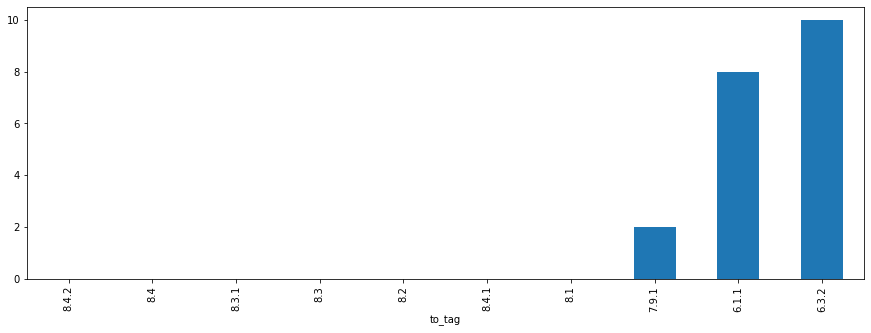

In [75]:
plt.figure()
tags_comparison.set_index("to_tag")["n_jobs"].sort_values().head(10).plot(kind="bar")
plt.savefig(f"{figure_folder}/job_selection_per_release/direct_approach_jobs_per_release.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Dataframes with job ids from difference commits and jobs ids from pull requests for each pair**

In [76]:
jobs_from_direct = pd.DataFrame(direct_data, columns=["from_tag", "to_tag", "job_id"])
jobs_from_direct.to_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct.csv")

<AxesSubplot:>

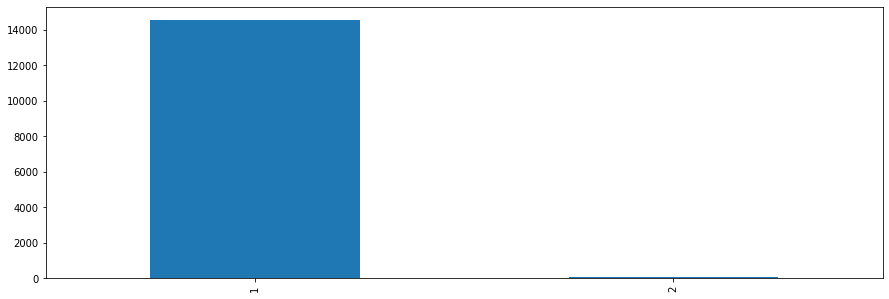

In [77]:
tags_comparison_commits.groupby(["ahead_sha"]).to_tag.count().value_counts().plot(kind="bar")

Text(0, 0.5, 'number of jobs')

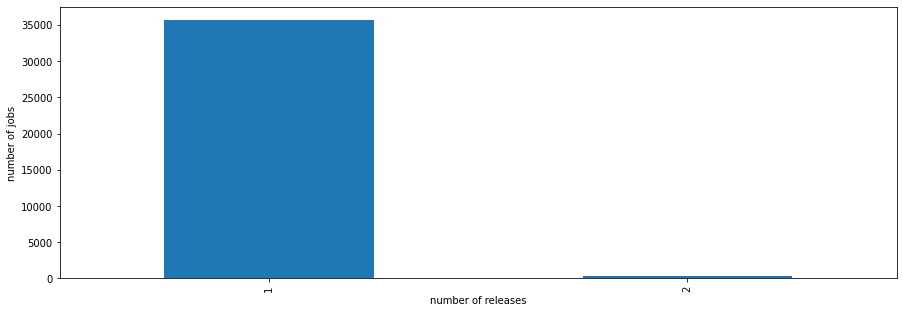

In [78]:
ax = jobs_from_direct.groupby(["job_id"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of jobs")

**How many jobs did we include**

In [79]:
len(set(jobs_from_direct.job_id)) / jobs.id.nunique()

0.2636823547447493

### Merge requests jobs (curiosity)

In [80]:
merge_data = []
def get_n_merge_jobs(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    for jobid in j.id:
        merge_data.append((row.from_tag, row.to_tag, jobid))
    return len(j[j.commitref.str.contains("merge").fillna(False)])

In [81]:
tags_comparison["n_merge_jobs"] = tags_comparison.apply(get_n_merge_jobs, axis=1)

<AxesSubplot:>

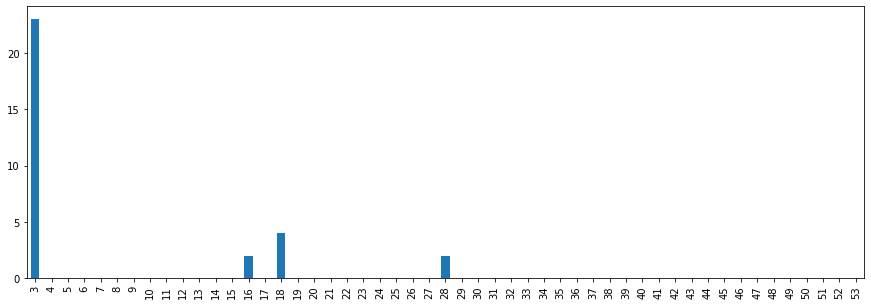

In [82]:
tags_comparison["n_merge_jobs"].plot(kind="bar")

### Pull request data

from :https://docs.travis-ci.com/user/pull-requests/#double-builds-on-pull-requests
* Rather than build the commits that have been pushed to the branch the pull request is from, we build the merge between the source branch and the upstream branch.

When only looking at the difference in commits between the two tags we may miss out on some pull request builds because Travis CI does not build the commits from the source branch (which are the commits we get as difference) but "fictive commits" which are the merge of the source and upstream branch.
Therefore in order to get a complete picture of the process of development of the release, we need to include these as well.

We do it by retrieving for each difference commit the pull request which match that commit in their head commit (the commit which is to be merged into the target branch in case of a fast forward) or in the merge_commit_sha. Once the list of pull requests is obtained, we query all the jobs which are associated with that pull request via its number.

In [83]:
pr_job_data = []
pr_data = []
def get_n_pull_request_jobs(row):
    tags_comparison_commits_example = tags_comparison_commits[(tags_comparison_commits.from_tag==row.from_tag) \
                                    & (tags_comparison_commits.to_tag==row.to_tag)].ahead_sha

    #commits_pr = pr_commits[pr_commits.commitsha.isin(tags_comparison_commits_example)]
    pull_requests = prs[(prs.head_sha.isin(tags_comparison_commits_example)) & (prs.merged)]
    pull_requests = pull_requests.append(prs[prs.merge_commit_sha.isin(tags_comparison_commits_example) & (prs.merged)])
    
    df = []
    for i, pr_number in enumerate(pull_requests.pr_number.unique()):
        if i == 0:
            df = jobs[jobs.commitref.str.contains(f"pull/{pr_number}").fillna(False)]
        else:
            df = pd.concat([df, jobs[jobs.commitref.str.contains(f"pull/{pr_number}").fillna(False)]]) 
        pr_data.append((row.from_tag, row.to_tag, pr_number))
    if(len(df)>0):
        for jobid in df.id:
            pr_job_data.append((row.from_tag, row.to_tag, jobid))
    return len(df)

In [84]:
tags_comparison["n_pull_request_jobs"] = tags_comparison.apply(get_n_pull_request_jobs, axis=1)

In [85]:
tags_prs = pd.DataFrame(pr_data, columns=["from_tag", "to_tag", "pr_number"])
jobs_from_direct_prs = pd.DataFrame(pr_job_data, columns=["from_tag", "to_tag", "job_id"])
jobs_from_direct_prs.to_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct_prs.csv")

Text(0, 0.5, 'number of jobs')

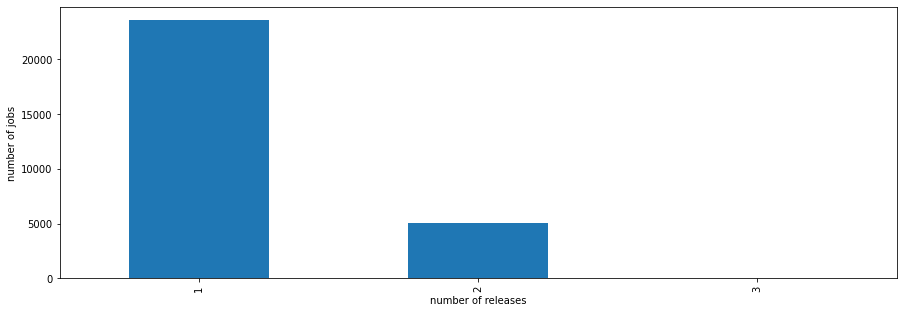

In [86]:
ax = jobs_from_direct_prs.groupby(["job_id"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of jobs")

<AxesSubplot:xlabel='to_tag'>

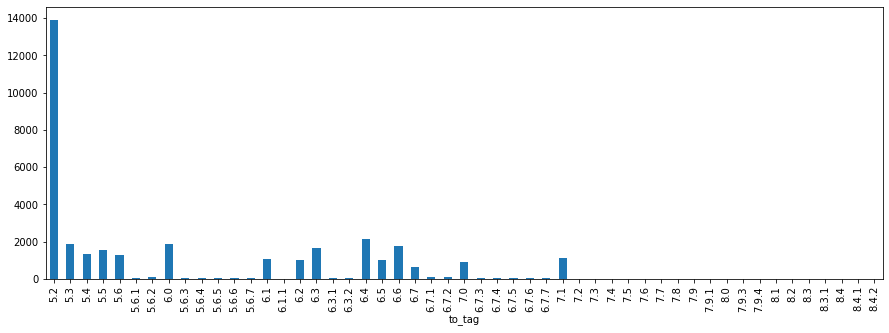

In [87]:
tags_comparison.set_index("to_tag").n_pull_request_jobs.plot(kind="bar")

In [88]:
jobs_from_direct_direct_pr = jobs_from_direct.append(jobs_from_direct_prs)
len(set(jobs_from_direct_direct_pr.job_id)) / jobs.id.nunique()

0.47341640933546497

**Pr + direct approach**

In [89]:
tags_comparison["direct_pr_jobs"] = tags_comparison.n_jobs + tags_comparison.n_pull_request_jobs

In [90]:
tags_comparison["direct_pr_jobs"].describe()

count       51.000000
mean      1380.549020
std       3727.976627
min          0.000000
25%         30.000000
50%        116.000000
75%       1323.500000
max      24843.000000
Name: direct_pr_jobs, dtype: float64

<AxesSubplot:xlabel='direct_pr_jobs'>

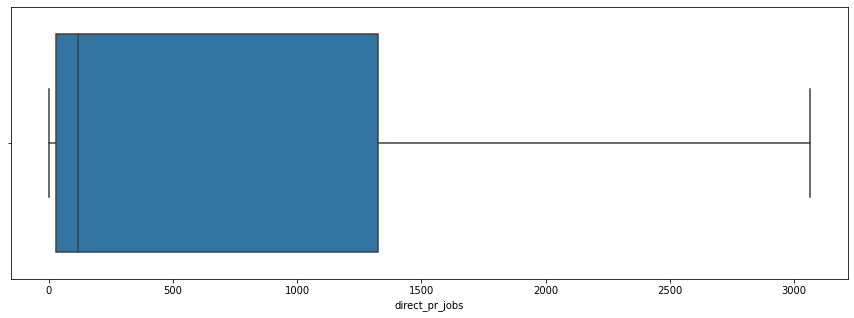

In [91]:
sns.boxplot(x=tags_comparison["direct_pr_jobs"], showfliers=False)

### Analyse the type of pull requests for each pair

data = []
def pull_requests_analysis(row):
    if row.name == 873:
        return
    tags_comparison_commits_example = tags_comparison_commits[(tags_comparison_commits.from_tag==row.from_tag) \
                                    & (tags_comparison_commits.to_tag==row.to_tag)].ahead_sha

    commits_pr = pr_commits[pr_commits.commitsha.isin\
           (tags_comparison_commits_example)]
    
    #pull_requests = prs[prs.pr_number.isin(commits_pr.pr_number)]
    pull_requests = prs[(prs.merge_commit_sha.isin(tags_comparison_commits_example))\
                       | (prs.head_sha.isin(tags_comparison_commits_example))]
    
    pr_merged_in_master = 0
    pr_merged_in_feature_branch = 0
    pr_merged_from_master = 0
    pr_merged_from_feature_branch = 0
    branches_to_analyse = []
    print("-"*20)
    print(f"{row.from_tag}->{row.to_tag}")
    for i, pr in pull_requests.iterrows():
        added = False
        #base
        if("master" == pr.base_ref):
            pr_merged_in_master+=1
        else:
            branches_to_analyse.append((pr.values))
            added=True
            pr_merged_in_feature_branch+=1
        #head
        if("master" == pr.head_ref):
            pr_merged_from_master+=1
        else:
            if(not added):
                branches_to_analyse.append((pr.values))
            pr_merged_from_feature_branch+=1
    
    print(f"pr_merged_in_master: {pr_merged_in_master}")
    print(f"pr_merged_in_feature_branch: {pr_merged_in_feature_branch}")
    print(f"pr_merged_from_master: {pr_merged_from_master}")
    print(f"pr_merged_from_feature_branch: {pr_merged_from_feature_branch}")
            
    for branch in branches_to_analyse:
        values = [row.from_tag, row.to_tag] + list(branch)
        data.append(tuple(values))
        #print(f"{branch[0]}, sha {branch[1][:6]}, {branch[2]}, sha {branch[3][:6]} has number jobs:", len(jobs[jobs.commitref==f"refs/heads/{branch[0]}"]))

x = tags_comparison.iloc[:-2]
x.apply(pull_requests_analysis, axis=1)

merged_branch = pd.DataFrame(data, columns=["from_tag", "to_tag"] + list(prs.columns))

merged_branch

merged_branch[(merged_branch.from_tag == "5.1.2") & (merged_branch.to_tag == "5.2") & (merged_branch.pr_number == 330)]

x = merged_branch.groupby(["head_ref", "head_sha"]).to_tag.count().reset_index()

x[x.to_tag > 1]

**How many pull requests associated with pairs?**

len(merged_branch)

**Investigate a pull request associated with more than 1 pair**

merged_branch[merged_branch.head_ref=="feature/jl/5.6_SONAR-8144"]

commit1 = tags_comparison_commits[(tags_comparison_commits.from_tag=="5.6.2") \
                                    & (tags_comparison_commits.to_tag=="5.6.3")]

commit2 = tags_comparison_commits[(tags_comparison_commits.from_tag=="6.1.1") \
                                    & (tags_comparison_commits.to_tag=="6.2")]

set(commit1.ahead_sha).intersection(set(commit2.ahead_sha))

This confirms that not all pairs have empty intersection. This is okay. Some changes are developed as fix or feature for a version and included into the upcoming one.

### Include jobs on the head branch of the merge requests before the pr was closed

def get_associated_jobs_before_pr(merged_branch):    
    job_ids_prs = []
    data = []
    for i, row in merged_branch.iterrows():
            job_ids_prs = jobs[(jobs.commitref==f"refs/heads/{row.head_ref}") & (jobs.created_at < row.closed_at)].id.values.tolist()
            for job_id in job_ids_prs:
                data.append((row.from_tag, row.to_tag, job_id))
    return data

t = tags_jobs[(tags_jobs.from_tag == "5.1.2") & (tags_jobs.to_tag == "5.2")]
tm = tags_merge_jobs[(tags_merge_jobs.from_tag == "5.1.2") & (tags_merge_jobs.to_tag == "5.2")]
commitmessages = list(t.merge(jobs[["id","commitmessage"]], left_on="job_id", right_on="id").commitmessage.unique())
commitmessages.append(list(tm.merge(jobs[["id","commitmessage"]], left_on="job_id", right_on="id").commitmessage.unique()))

jout[jout.commitmessage.isin(commitmessages)]

merged_branch

x = merged_branch[(merged_branch.from_tag == "5.1.2") & (merged_branch.to_tag == "5.2")][["pr_number", "closed_at","head_ref"]]
x

y = x.loc[2]
y

y.closed_at

In [93]:
jobs_before_pr_data = []
def associated_jobs_before_pr(row):    
    job_ids_prs = []
    _pr_numbers = tags_prs[(tags_prs.to_tag == row.to_tag) & (tags_prs.from_tag == row.from_tag)].pr_number
    _prs = prs[prs.pr_number.isin(_pr_numbers)]
    for i, pr in _prs.iterrows():
        if(pr.head_ref == "master"):
            print("Skipping master", row.from_tag, row.to_tag, pr.pr_number, pr.base_ref)
            continue
        job_ids_prs = jobs[(jobs.commitref==f"refs/heads/{pr.head_ref}") & (jobs.created_at < pr.closed_at)].id.values.tolist()
        for job_id in job_ids_prs:
            jobs_before_pr_data.append((row.from_tag, row.to_tag, job_id))
    return len(jobs_before_pr_data)

In [94]:
tags_comparison["n_jobs_before_pr"] = tags_comparison.apply(associated_jobs_before_pr, axis=1)

Skipping master 5.1.2 5.2 333 master
Skipping master 6.0 6.1 1194 master
Skipping master 6.0 6.1 1218 master
Skipping master 6.3.2 6.4 1843 master


In [95]:
jobs_head_ref_before_pr = pd.DataFrame(jobs_before_pr_data, columns=["from_tag", "to_tag", "job_id"])
jobs_head_ref_before_pr.to_csv(f"{csv_folder}/jobs_per_releases/jobs_head_ref_before_pr.csv")

Text(0, 0.5, 'number of jobs')

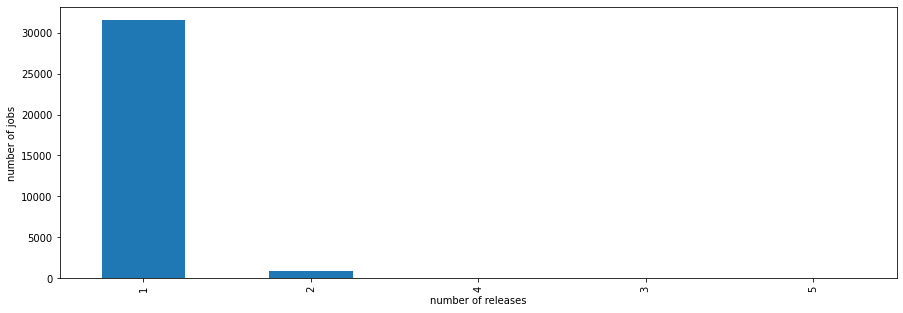

In [96]:
ax = jobs_head_ref_before_pr.groupby(["job_id"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of jobs")

**How many jobs do we leave out?**

In [97]:
jobs_head_ref_before_pr_from_direct_direct_pr = jobs_from_direct_direct_pr.append(jobs_head_ref_before_pr)
x = jobs_head_ref_before_pr_from_direct_direct_pr
len(set(x.job_id)) / jobs.id.nunique()

0.6807779067475526

### Investigate PRs left out

In [98]:
prs_out = prs[(~prs.pr_number.isin(tags_prs.pr_number.unique()))\
              & (prs.created_at > pd.to_datetime("2015-03-15 00:00:00+00:00"))]

In [99]:
prs_out.merged.value_counts(normalize=True)

False    0.728358
True     0.271642
Name: merged, dtype: float64

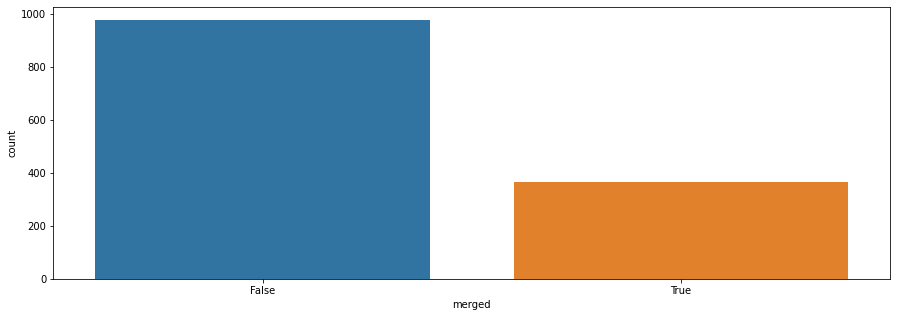

In [100]:
plt.figure()
sns.countplot(x=prs_out.merged)
plt.savefig(f"{figure_folder}/job_selection_per_release/merged_prs.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Prs merged into master**

More likely to be detected by our approach

In [101]:
len(prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]) / len(prs_out[(prs_out.merged==True)])

0.9972527472527473

In [102]:
prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref == "master")]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
444,3184,Corrected typo,2018-10-09 22:44:50+00:00,2018-10-15 18:50:28+00:00,closed,True,ed414e9ab4b47257bcf4e4462ee097dd4a2eb18a,a6e127b39f864078041f71552d51767f9bb374a5,master,e1f95b2763e52f72fbe855f170518a8621679f7e,patch-1


Indeed these left out pull requests look like they are merged into other master branches of other projects

**PRs not merged into master**

In [103]:
prs_out_not_master = prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]
#Prs from feature to feature
len(prs_out_not_master[(prs_out_not_master.head_ref.str.startswith("feature/"))\
                   & (prs_out_not_master.head_ref.str.startswith("feature/"))]) \
                   / len(prs_out_not_master)

0.9393939393939394

In [104]:
prs_out_not_master

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
250,2212,MMF-870 Apply feedbacks,2017-07-03 08:15:16+00:00,2017-07-03 10:25:30+00:00,closed,True,165ea2c44bb481c63fbb69e62eeaabe2b13ee380,9e5686fa47dc38b116020ec99b557432ac0b8600,feature/lambda/enhance_project_activity,1f66e0d73d7bbb106e0ff70af073f40f562ed7de,feature/greg/enhance_project_activity_feedback
255,2205,SONAR-9482 Display the number of 'Sonar way' r...,2017-06-29 11:52:38+00:00,2017-06-30 08:40:35+00:00,closed,True,0b8163856d3af6b0f99f60b8c84074daebe52e2d,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,feature/lambda/highlight_sonar_way_profile,92e8201451a7007d36c201a3a4d7056f07ef5191,feature/lambda/implement_qp_show_ws
260,2207,"SONAR-9483 Compare a profile with a ""Sonar way...",2017-06-30 08:44:13+00:00,2017-06-30 11:05:02+00:00,closed,True,601e89c0f429c7437360a3bcf96400c1314fdf8b,0b8163856d3af6b0f99f60b8c84074daebe52e2d,feature/lambda/highlight_sonar_way_profile,81e6304cb1d7b6b435e06d86ef7d6ababf1fb86a,feature/lambda/add_compare_to_in_rules_search
261,2226,SONAR-9403 Add custom graph to the project act...,2017-07-07 11:03:36+00:00,2017-07-11 09:13:08+00:00,closed,True,74c53b85629ef84e572a6c9a94cc2f52019c024a,784299357d62cfb87b1885bf3bb87dbc2ed3144d,feature/lambda/understand-history-project,5de233dc7d54131c7dc9d73ac664295da4c10bec,feature/greg/custom-graph-history-project
265,2206,Highlight sonar way quality profiles,2017-06-29 12:15:12+00:00,2017-06-30 06:34:51+00:00,closed,True,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,7497736b259aafd0457411343ec14993d3566a17,feature/lambda/highlight_sonar_way_profile,574e458f3601afc69c57045b03d1ccde566261c2,feature/greg/highlight_sonar_way_profile
267,2220,SONAR-9418 Add activity interaction,2017-07-05 15:01:50+00:00,2017-07-05 16:05:43+00:00,closed,True,8b48c420723ed51405ec3ed1ccd4b6b7a991e856,7bd9f008ca0d9bf1b5b6cb75d10ba0ce0dd281d1,feature/lambda/understand-history-project,9198a555bee1f96a06736d7ca568a84ad7a376a7,feature/greg/project_activity_interaction
269,2223,SONAR-9508 Create api/ce/worker_count WS,2017-07-06 08:21:33+00:00,2017-07-06 09:34:17+00:00,closed,True,1cd3c185bffd49a44c96f434a3d016893771ada1,fd6a1b6a1c24564077d7bf8d2595b6d470bc9aa5,feature/platform/move_worker_count_to_gov,b823e5205efcdef8214e0174693bd9e02c1ba596,feature/jl/create_worker_count_ws
275,2217,SONAR-9507 ce worker count as internal property,2017-07-04 16:23:24+00:00,2017-07-06 08:16:38+00:00,closed,True,b940617d5719963c8337886d13afe1b34fb2461b,2e3eb0e482ff93b5c30189eca126a58e45e9221a,feature/platform/move_worker_count_to_gov,b940617d5719963c8337886d13afe1b34fb2461b,feature/sl/SONAR-9507/ce_worker_count_as_inter...
277,2231,SONAR-9525 dynamic ce workers,2017-07-10 09:17:31+00:00,2017-07-11 15:06:59+00:00,closed,True,aba4c66e9a547a2b45fc26dced52014b948f95f4,7da4f278af130240bdab1e5b5729e4e9c0296a59,feature/platform/move_worker_count_to_gov,aba4c66e9a547a2b45fc26dced52014b948f95f4,feature/sl/SONAR-9525/dynamic_ce_workers
284,2225,SONAR-9508 Display worker counter in backgroun...,2017-07-07 09:37:41+00:00,2017-07-10 07:21:12+00:00,closed,True,fb4a5434cac6bcd5352a31dd0c2ba1a93e0d76c6,1cd3c185bffd49a44c96f434a3d016893771ada1,feature/platform/move_worker_count_to_gov,df0c72fbd2986b64344a3d8f5cc4c595bec5e875,feature/stas/change-worker-count


In [105]:
prs_out_not_master[~(prs_out_not_master.head_ref.str.startswith("feature/"))\
                   | ~(prs_out_not_master.head_ref.str.startswith("feature/"))]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
482,1555,SONAR-8630 query by filename and ext,2017-01-24 09:11:19+00:00,2017-01-24 16:32:29+00:00,closed,True,7b8f2625c5e300fca301bd2b2a0ddb5fd9055bc0,c450df58ac242224332e28f5bab406bb4fd93634,publish_files_rebased,53abebb8493ef49cd0858b396330b892f391a342,SONAR-8630-query-by-filename-and-ext
812,2426,SONAR-9616 Use base branch to get project repo...,2017-08-24 15:30:23+00:00,2017-08-25 14:26:57+00:00,closed,True,e05bce6df9fe4647b906e64bcde095bf03c4a72e,239aea96e7f425ae5dfd9fbbc56c1debf731e299,feature/branches,5c1da16c02a96f9cae308b7951351a95045953e3,janos/use-base-branch-to-get-project-repository
816,2450,SONAR-9616 Fix notifications on branches,2017-08-30 07:16:22+00:00,2017-08-30 15:20:32+00:00,closed,True,d12f4c2dc49558764c32c8e0a7745f36dd8f14b6,ed1f45a01671998c27e4a01a351b13684563bf9a,feature/branches,155673cbe00db41c7f3b3d1a00f5a1c96bbd914b,janos/fix-notifications-on-branches
848,2413,SONAR-9616 Support notifications on branches,2017-08-23 15:53:04+00:00,2017-08-24 12:20:52+00:00,closed,True,39bc90f4bb52f745300ca75ac4a6ae942dc4d578,5b4b405daa5a8b308069ecbc50358c7b8d0e7863,feature/branches,6f5b7725f69fda1d99732f2e9cbe0bf5d4edbf89,janos/notifications-on-branches
1007,2344,Dm/feature/branches,2017-08-11 09:00:19+00:00,2017-08-11 11:32:15+00:00,closed,True,5fae362002fd83371de165e651f99ac496033901,000d49327e62a55861020b8ea137f0b91277e336,feature/branches,a1004c19fd3a88e4b9c409fd7d60a70a94c5a475,dm/feature/branches
1009,2332,Respond with 404 when project missing in /api/...,2017-08-09 13:09:07+00:00,2017-08-10 08:03:32+00:00,closed,True,88a067b9a85c950741b77f3486aa954a54a01a32,1b5d5dc44110c5282dca3acbd3f8c12cfc463e10,feature/branches,58eb25d90b632eb040306175b976a594298c054d,fix-project-branches
1012,2320,SONAR-9674 Load branch type (long/short) from ...,2017-08-03 13:51:12+00:00,2017-08-04 08:21:04+00:00,closed,True,d1124ea12d2cd0bc7817a00ce360bd113b0e1e6e,b7f966d9e85a923adbfad7f8b2cc65366997a9d6,feature/MMF-972/long-branches-rebased-on-incre...,0effc428f9b03d41066d6e0a0363c8f2e2d66ab9,dm/short-branches
1013,2329,Dm/short branches,2017-08-07 13:38:16+00:00,2017-08-08 09:44:35+00:00,closed,True,1b5d5dc44110c5282dca3acbd3f8c12cfc463e10,89a70f703dfb9477683d11991d7e5cf3b0f002ea,feature/branches,92bb76c1c68003e4424d67455144473a1e915777,dm/short-branches
1016,2327,SONAR-9675 detect branch type,2017-08-07 10:05:07+00:00,2017-08-11 07:25:55+00:00,closed,True,000d49327e62a55861020b8ea137f0b91277e336,a09dcfaeb9aa284f457b56e28ab899bbe29137f2,feature/branches,1583be582e78629dfdcf75e6946e410497b21e3b,janos/SONAR-9675-detect-branch-type
1021,2303,Dm/feature/incremental2,2017-07-27 14:48:42+00:00,2017-08-02 14:35:23+00:00,closed,True,021be7deae1b11c211a37073bcde571fe29c9a04,dc786a0e9229d95a7226b4f8b24cc322b24672a4,feature/incremental,021be7deae1b11c211a37073bcde571fe29c9a04,dm/feature/incremental2


The problem are feature branches merged into other feature branches. Our approach is likely not to identify these PRs as belonging to a release beacuse there may be no reference of these PRs commits (either head or merge commit) into the commit difference list of a releases, due to merge commits, squashing and rebasing which may hide this commit history of merges. We can look at the builds from these branches which we have identified as relevant for our release and reapply our approach in an iterative manner to detect PRs affecting them and stop when the searched has converged and does not add any new commits.

In [106]:
def get_prs_given_commits(commits):
    #print(commits)
    return prs[((prs.head_sha.isin(commits))|\
                       (prs.merge_commit_sha.isin(commits))) & (prs.merged)]

def get_jobs_ids_for_head_branch_in_pr(prs):
    _j = set()
    for i, row in prs.iterrows():
        _i = jobs[(jobs.commitref==f"refs/heads/{row.head_ref}")\
                                         & (jobs.created_at < row.closed_at)].id.values.tolist()
        _m = jobs[(jobs.commitref==f"refs/pull/{row.pr_number}/merge")\
                                         & (jobs.created_at < row.closed_at)].id.values.tolist()
        _j = _j.union(_i).union(_m)
    return _j

**Implementation of our iterative algorithm**

In [107]:
tags_comparison_commits_list = tags_comparison_commits.groupby(["from_tag","to_tag"]).ahead_sha.apply(list).reset_index()
commit_data = []
prs_data = []
iteration_data = []
for i, row in tags_comparison_commits_list.iterrows():
    _commits = set(row.ahead_sha)
    _iterations = 0
    while True:
        _iterations+=1
        print(f"Iteration n {_iterations} for {row.from_tag} {row.to_tag}")
        _current_n_commits = len(_commits)
        #Get pull requests
        _prs = get_prs_given_commits(_commits)
        #print(_prs.pr_number.unique())
        for i, _pr in _prs.iterrows():
            prs_data.append((row.from_tag, row.to_tag, _pr.pr_number))
        #print(len(_prs))
        _job_ids_prs = get_jobs_ids_for_head_branch_in_pr(_prs)
        _job_ids_prs
        #print(len(_job_ids_prs))
        _new_commits = set(jobs[jobs.id.isin(_job_ids_prs)].commitsha)
        _commits = _commits.union(_new_commits)
        if(len(_commits) == _current_n_commits):
            break
    for _commit in _commits:
        commit_data.append((row.from_tag, row.to_tag, _commit))
    iteration_data.append((row.from_tag, row.to_tag, _iterations))

Iteration n 1 for 5.1 5.1.1
Iteration n 1 for 5.1.1 5.1.2
Iteration n 1 for 5.1.2 5.2
Iteration n 2 for 5.1.2 5.2
Iteration n 1 for 5.2 5.3
Iteration n 2 for 5.2 5.3
Iteration n 3 for 5.2 5.3
Iteration n 1 for 5.3 5.4
Iteration n 2 for 5.3 5.4
Iteration n 1 for 5.4 5.5
Iteration n 2 for 5.4 5.5
Iteration n 1 for 5.5 5.6
Iteration n 2 for 5.5 5.6
Iteration n 1 for 5.6 5.6.1
Iteration n 2 for 5.6 5.6.1
Iteration n 1 for 5.6.1 5.6.2
Iteration n 2 for 5.6.1 5.6.2
Iteration n 1 for 5.6.1 6.0
Iteration n 2 for 5.6.1 6.0
Iteration n 1 for 5.6.2 5.6.3
Iteration n 2 for 5.6.2 5.6.3
Iteration n 1 for 5.6.3 5.6.4
Iteration n 2 for 5.6.3 5.6.4
Iteration n 1 for 5.6.4 5.6.5
Iteration n 2 for 5.6.4 5.6.5
Iteration n 1 for 5.6.5 5.6.6
Iteration n 2 for 5.6.5 5.6.6
Iteration n 1 for 5.6.6 5.6.7
Iteration n 2 for 5.6.6 5.6.7
Iteration n 1 for 6.0 6.1
Iteration n 2 for 6.0 6.1
Iteration n 3 for 6.0 6.1
Iteration n 1 for 6.1 6.1.1
Iteration n 1 for 6.1.1 6.2
Iteration n 2 for 6.1.1 6.2
Iteration n 3 for 

In [109]:
tags_pairs_iterations = pd.DataFrame(iteration_data, columns=["from_tag", "to_tag", "n_iterations"])
tags_pairs_iterations.head(2)

,from_tag,to_tag,n_iterations
0,5.1,5.1.1,1
1,5.1.1,5.1.2,1


In [110]:
tags_pairs_iterations.n_iterations.value_counts()

2    21
1    13
3     8
4     4
Name: n_iterations, dtype: int64

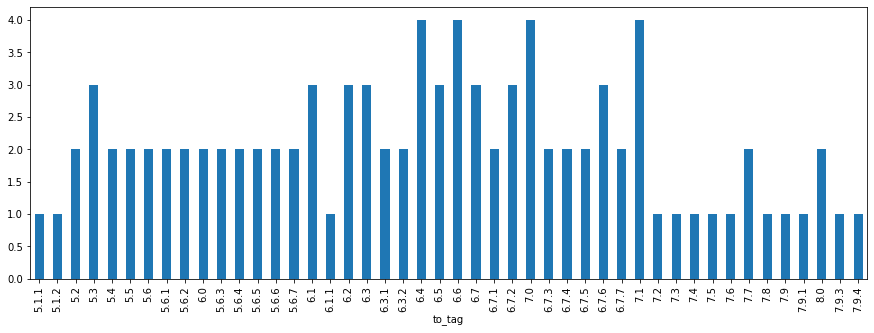

In [111]:
plt.figure()
tags_pairs_iterations.set_index("to_tag").n_iterations.plot(kind="bar")
plt.savefig(f"{figure_folder}/job_selection_per_release/iterations_prs.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [112]:
tags_prs_iterative = pd.DataFrame(prs_data, columns=["from_tag", "to_tag", "pr_number"])
tags_prs_iterative.head()

,from_tag,to_tag,pr_number
0,5.1.1,5.1.2,403
1,5.1.2,5.2,475
2,5.1.2,5.2,499
3,5.1.2,5.2,462
4,5.1.2,5.2,496


In [113]:
jobs.shape

(136983, 13)

In [114]:
tags_pairs_commits = pd.DataFrame(commit_data, columns=["from_tag", "to_tag", "commitsha"])
jobs_iterative_approach = tags_pairs_commits.merge(jobs, on="commitsha")[["from_tag", "to_tag", "id"]].rename(columns={"id":"job_id"})

In [115]:
jobs_iterative_approach.to_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_approach.csv")

In [118]:
jobs_iterative_approach = jobs_iterative_approach.drop_duplicates(ignore_index=True)

In [119]:
jobs[jobs.id == 144503564]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
59714,144503564,144503563,2016-07-13 16:41:15+00:00,2016-07-13 16:13:55.156000+00:00,2016-07-13 16:56:42+00:00,11840.1,passed,2018-05-31 02:32:18.973000+00:00,71624bb5617ab6ffb67de3f07757b33cc8ebb83d,40988661,SONAR-7753 allow system admins to access proje...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...


In [120]:
jobs_iterative_approach[jobs_iterative_approach.job_id==144503564]

,from_tag,to_tag,job_id
153344,5.6.1,6.0,144503564
153358,6.0,6.1,144503564
153372,6.3.2,6.4,144503564
153386,6.5,6.6,144503564


In [121]:
prs[prs.head_ref=="feature/sb/SONAR-11680"]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
401,3196,SONAR-11680 upgrade Tomcat to 8.5.37,2019-02-07 12:56:13+00:00,2019-02-07 16:08:20+00:00,closed,True,1d12ea0bec9843400ec62e378df0730834220545,d2f6a51f791ab430da08bea7dc46373288274ffb,master,43730b44f13fc5dd93173bfafbdd1796c839dbdb,feature/sb/SONAR-11680


In [122]:
jobs[jobs.commitref=="refs/heads/feature/sb/SONAR-11680"]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
130170,490035357,490035356,2019-02-07 12:54:06+00:00,2019-02-07 12:53:29.690000+00:00,2019-02-07 13:20:27+00:00,38854.1,passed,2019-02-07 13:20:27.182000+00:00,43730b44f13fc5dd93173bfafbdd1796c839dbdb,147644800,SONAR-11680 upgrade Tomcat to 8.5.37,refs/heads/feature/sb/SONAR-11680,https://github.com/SonarSource/sonarqube/commi...
130171,490035358,490035356,2019-02-07 12:53:57+00:00,2019-02-07 12:53:29.698000+00:00,2019-02-07 13:01:55+00:00,38854.2,passed,2019-02-07 13:01:55.211000+00:00,43730b44f13fc5dd93173bfafbdd1796c839dbdb,147644800,SONAR-11680 upgrade Tomcat to 8.5.37,refs/heads/feature/sb/SONAR-11680,https://github.com/SonarSource/sonarqube/commi...


In [123]:
prs[prs.merge_commit_sha=="43730b44f13fc5dd93173bfafbdd1796c839dbdb"]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref


In [124]:
x = jobs[jobs.id.isin(get_jobs_ids_for_head_branch_in_pr(prs[prs.pr_number==3196]))].commitsha
get_prs_given_commits(x)

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
401,3196,SONAR-11680 upgrade Tomcat to 8.5.37,2019-02-07 12:56:13+00:00,2019-02-07 16:08:20+00:00,closed,True,1d12ea0bec9843400ec62e378df0730834220545,d2f6a51f791ab430da08bea7dc46373288274ffb,master,43730b44f13fc5dd93173bfafbdd1796c839dbdb,feature/sb/SONAR-11680


In [125]:
get_prs_given_commits(tags_comparison_commits[(tags_comparison_commits.from_tag=="7.6") & (tags_comparison_commits.to_tag=="7.7")].ahead_sha)

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
401,3196,SONAR-11680 upgrade Tomcat to 8.5.37,2019-02-07 12:56:13+00:00,2019-02-07 16:08:20+00:00,closed,True,1d12ea0bec9843400ec62e378df0730834220545,d2f6a51f791ab430da08bea7dc46373288274ffb,master,43730b44f13fc5dd93173bfafbdd1796c839dbdb,feature/sb/SONAR-11680


In [128]:
x = jobs_iterative_approach.groupby(["job_id"]).to_tag.count()
x[x == 4]

job_id
72858178     4
72858179     4
72858180     4
72858181     4
72858182     4
72858183     4
72858185     4
72858186     4
72858187     4
72858188     4
72858189     4
72860759     4
72860762     4
72860765     4
72860768     4
72860772     4
72860777     4
72860781     4
72860784     4
72860787     4
72860790     4
72860793     4
72964167     4
72964168     4
72964169     4
72964170     4
72964171     4
72964172     4
72964173     4
72964175     4
72964178     4
72964188     4
72964190     4
72964191     4
72964192     4
72964193     4
72964195     4
72964196     4
72964197     4
72964198     4
72981182     4
72981183     4
72981184     4
72981185     4
72981186     4
72981187     4
72981188     4
72981189     4
72981190     4
72981191     4
72981192     4
72981202     4
72981203     4
72981204     4
72981205     4
72981206     4
72981209     4
72981211     4
72981212     4
72981213     4
72981214     4
72981215     4
72981305     4
72981306     4
72981307     4
72981308     4
729

Text(0, 0.5, 'number of jobs')

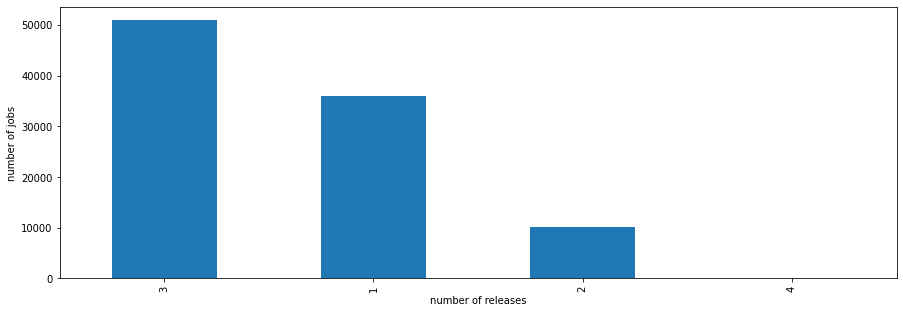

In [129]:
ax = jobs_iterative_approach.groupby(["job_id"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of jobs")

In [130]:
jobs_iterative_approach.job_id.nunique() / len(jobs)

0.7094967988728529

**Investigate included PRs**

Should we exclude the not merged ones?

In [131]:
prs_included = prs[prs.pr_number.isin(tags_prs_iterative.pr_number)]
prs_included[~prs_included.merged]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref


**Investigate not included PRs**

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='merged', ylabel='count'>

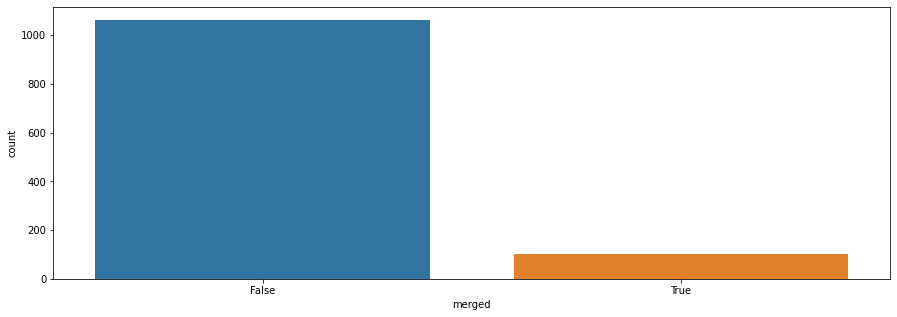

In [132]:
sns.countplot(prs[~prs.pr_number.isin(tags_prs_iterative.pr_number)].merged)

They are mostly not merged PRs. What about the merged ones?

In [133]:
prs[(~prs.pr_number.isin(tags_prs_iterative.pr_number)) \
    & (prs.created_at > pd.to_datetime("2015-03-05 14:39:13+00:00")) & (prs.merged)]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
351,2606,SONAR-9882,2017-10-02 15:03:40+00:00,2017-10-03 13:39:09+00:00,closed,True,0f7be9c7a2e04aec945dcb9f399e0962de2c1ce0,665c76ed3ff786ec84d51a61a825a048668dd3f4,feature/atlas/MMF-988/webhook_call_on_issue_ch...,b3d62bc8f6a41f3c089f115f37ef5849694ed6f5,feature/eh/SONAR-9882
372,2634,SONAR-9871 call project webhook on issue chang...,2017-10-09 09:22:14+00:00,2017-10-09 15:19:28+00:00,closed,True,9158491cca6240b4c0bfa66a87d122275b1af707,327dfa90bc92133bf903cee0619104220b197351,feature/atlas/MMF-988/webhook_call_on_issue_ch...,9158491cca6240b4c0bfa66a87d122275b1af707,feature/sl/SONAR-9871/call_project_webhook_on_...
412,3157,SONAR-9338 Make all date pickers consistent,2018-03-15 16:24:39+00:00,2018-03-16 15:24:04+00:00,closed,True,fd7209384d5f2d7ba3e23f36e9b330bb8f5b4234,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e18524ff695bf0d4d90552258236da04dc2d06d9,feature/stas/datepicker
425,3151,Move VSTS extension to its own module,2018-03-13 16:51:22+00:00,2018-03-15 09:09:56+00:00,closed,True,360b53b020a193ff3c377779e0e69d2c5e91c75f,49c2d1701c09f9cca80c8fed6b0ef49327d5b0cc,feature/MMF-1123/vsts_integration,1dfe666aee64406626b563237349d2bf17f403cf,feature/greg/vsts_move_to_module
429,3152,Rewrite SelectList component in React on Quali...,2018-03-14 09:30:30+00:00,2018-03-16 15:21:30+00:00,closed,True,5b5b8896faa4f135c39ce894e7084a7e0a5f0f6f,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e33fc12cd28cbd464977643483f1d251c2320686,feature/pm/rewriting-selectlist-in-react
444,3184,Corrected typo,2018-10-09 22:44:50+00:00,2018-10-15 18:50:28+00:00,closed,True,ed414e9ab4b47257bcf4e4462ee097dd4a2eb18a,a6e127b39f864078041f71552d51767f9bb374a5,master,e1f95b2763e52f72fbe855f170518a8621679f7e,patch-1
584,291,feature/fix_mssql_role,2015-05-05 20:47:30+00:00,2015-05-06 21:00:22+00:00,closed,True,053bdad7ba27899fa5eab6a99cdd6b10e5e941b4,543e5a352f60add1eeef61ad3c4dba7ce826bdb6,branch-4.5,f0d72ab12bda27a060554042db2d09b3e672a823,feature/fix_mssql_role
708,1915,Create members group when creating org,2017-04-10 14:56:38+00:00,2017-04-11 14:27:36+00:00,closed,True,627c7e7b9298d947a3965724f18e8648a5b4379c,c769fb54f7167b56fd603304feedd12a84393bc2,feature/lambda/add_default_group_in_organizations,627c7e7b9298d947a3965724f18e8648a5b4379c,feature/jl/create_members_group_when_creating_org
738,1934,"SONAR-9115 let api/rules/create fail, if organ...",2017-04-13 15:27:27+00:00,2017-04-14 07:00:06+00:00,closed,True,7557e66df346d698cd9894cd6ea785732a68a624,a7d3c82fa1c316c312ff7dbb9502bc1a82fd7665,feature/daniel/MMF-838/make_rules_ws_organizat...,1615b82d592912d9f87ff1fbf918a1f721eb9c48,feature/daniel/MMF-838/SONAR-9115/fail_custom_...
778,2984,SONAR-10313 change route and key of issue to i...,2018-01-25 09:45:12+00:00,2018-02-05 16:24:05+00:00,closed,True,f20057b318d07fdfd72f041f0d300874d614339b,76f37d0564f865e87d558b0169ce8424bc9cafcc,feature/MMF-1153/support_rule_key_renaming,f20057b318d07fdfd72f041f0d300874d614339b,feature/sl/7.1/SONAR-10313/remove_key_from_rul...


**Investigate not assigned jobs**

In [134]:
jout = jobs[~jobs.id.isin(jobs_iterative_approach.job_id.unique())]
jout

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
180,242404698,242404697,2017-06-13 12:56:17+00:00,2017-06-13 12:43:13.361000+00:00,2017-06-13 12:57:33+00:00,25704.1,canceled,2018-06-02 15:00:52.531000+00:00,957b943f1559831f80845d1b293a0aa0cc833eac,70319990,Support recent browsers in Selenese HTML tests,refs/heads/feature/sb/selenese-chrome,https://github.com/SonarSource/sonarqube/commi...
181,242404699,242404697,2017-06-13 12:56:58+00:00,2017-06-13 12:43:13.385000+00:00,2017-06-13 12:57:33+00:00,25704.2,canceled,2018-06-02 15:00:52.541000+00:00,957b943f1559831f80845d1b293a0aa0cc833eac,70319990,Support recent browsers in Selenese HTML tests,refs/heads/feature/sb/selenese-chrome,https://github.com/SonarSource/sonarqube/commi...
182,242405186,242405185,2017-06-13 12:58:13+00:00,2017-06-13 12:44:43.193000+00:00,2017-06-13 13:09:21+00:00,25705.1,passed,2018-06-02 15:00:42.291000+00:00,b438ca00f05df5f54ea014f9706fbf317de2eb2c,70320158,Support recent browsers in Selenese HTML tests,refs/pull/2166/merge,https://github.com/SonarSource/sonarqube/pull/...
183,242405187,242405185,2017-06-13 12:58:32+00:00,2017-06-13 12:44:43.223000+00:00,2017-06-13 13:03:11+00:00,25705.2,passed,2018-06-02 15:00:42.301000+00:00,b438ca00f05df5f54ea014f9706fbf317de2eb2c,70320158,Support recent browsers in Selenese HTML tests,refs/pull/2166/merge,https://github.com/SonarSource/sonarqube/pull/...
212,181464352,181464351,2016-12-05 20:40:07+00:00,2016-12-05 20:39:59.230000+00:00,2016-12-05 20:54:13+00:00,15736.1,passed,2018-06-01 16:26:24.712000+00:00,9178026afd12c8cb45cd6b83af500c8b81de629a,51794052,SONAR-5471 drop data change migrations of 5.3,refs/heads/feature/sb/compress-ruby-migrations,https://github.com/SonarSource/sonarqube/compa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136966,315384398,315384395,2017-12-12 14:26:19+00:00,2017-12-12 14:25:30.478000+00:00,2017-12-12 14:29:36+00:00,34805.2,passed,2018-06-03 16:57:05.916000+00:00,9521be1f628b8a6c7275fbcf2275bc7aa84b99d0,93633590,SONAR-10117 add test on error handling in Live...,refs/pull/2901/merge,https://github.com/SonarSource/sonarqube/pull/...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136980,315421140,315421138,2017-12-12 15:43:26+00:00,2017-12-12 15:42:34.682000+00:00,2017-12-12 15:44:25+00:00,34812.2,passed,2018-06-03 16:57:47.778000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136981,315421147,315421146,2017-12-12 15:43:25+00:00,2017-12-12 15:42:40.583000+00:00,2017-12-12 16:01:05+00:00,34813.1,passed,2018-06-03 16:57:47.837000+00:00,a5005e0ca38a67e7d70c255154990ed10be31020,93645838,SONAR-10187 Provide more options to populate e...,refs/pull/2895/merge,https://github.com/SonarSource/sonarqube/pull/...


## Include jobs with same commit message  (cherry picked commits)

In [135]:
tags_comparison_commits

,ahead_sha,commit_message,files_changed,to_tag,from_tag
0,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,Release 5.1.1,M\tmicrobenchmark-template/pom.xml\nM\tplugins...,5.1.1,5.1
1,5fd94339043014de03f0e9f99298f89851cd93c6,drop unstable web tests,D\tserver/sonar-web/src/main/js/tests/e2e/test...,5.1.1,5.1
2,6896435a3ee2ebadfbb0c47b815c61850539a3b9,SONAR-6398 Restore PostJob execution in previe...,M\tsonar-batch/src/main/java/org/sonar/batch/p...,5.1.1,5.1
3,e4c01a6e0c962a41b23a4f10f146a9a2a9c01e80,SONAR-6566 Unable to deliver notifications on ...,M\tserver/sonar-server/src/main/java/org/sonar...,5.1.1,5.1
4,96651c2341184362a22b89fe7a8e24b2a23b4695,SONAR-6493 java.lang.NullPointerException in t...,M\tserver/sonar-server/src/main/java/org/sonar...,5.1.1,5.1
...,...,...,...,...,...
14701,54ad43e764d1213243458d71b2c06aef11ecdbe5,SONAR-13328 fix SSF-106,M\tsonar-application/build.gradle,7.9.4,7.9.3
14702,72c602efb630c1d843cefdf185a54b20c313e13d,SONAR-12886 Update LTS handling in static docu...,M\tserver/sonar-docs/src/@types/types.d.ts\nM\...,7.9.4,7.9.3
14703,281f480cfd65d85ebb27da9e77f15dbf71cb7f54,SONAR-13259 Fix branch analysis on Travis CI f...,M\ttravis.sh,7.9.4,7.9.3
14704,93bf42f81310013436f2d5ef60b60d8714a32f5f,increase analysis log level,M\ttravis.sh,7.9.4,7.9.3


In [136]:
same_commitmessage_jobs_data = []
def get_n_same_commitmessage_jobs(row):
    commitmessages = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag) &\
                                             (tags_comparison_commits.commit_message.str.contains("SONAR-"))].commit_message
    j = jobs[jobs.commitmessage.isin(commitmessages)]
    for jobid in j.id:
        same_commitmessage_jobs_data.append((row.from_tag, row.to_tag, jobid))
    return len(j)

In [187]:

def is_cherry_picked_from(row):
    res = []
    commitmessage = row.commit_message
    if commitmessage in no_cherry_pick:
        return res
    sha = row.ahead_sha
    j = jobs[(jobs.commitref == "refs/heads/master") &\
             (jobs.commitmessage == commitmessage)&(jobs.commitsha != sha)]
    cherry_picked_candidates_shas = j.commitsha.unique()
    for cps in cherry_picked_candidates_shas:
        files_changed = get_files_changed(cps)
        if(files_changed == row.files_changed):
            res.append(cps)
    return res

In [293]:
no_cherry_pick = ["[maven-release-plugin] prepare for next development iteration",
                 "Prepare for next development iteration"]

def cherry_picked_from_jobs(from_tag, to_tag, _commits, _jobs):
    res = []
    #for each commit
    for i, row in _commits.iterrows():
        commitmessage = row.commit_message
        if(not commitmessage.startswith("SONAR-")):
            continue
        if commitmessage in no_cherry_pick:
            return res
        sha = row.ahead_sha
        commit_date = commits_dates[commits_dates.commitsha==sha].iloc[0].date
        if(not commit_date):
            print("No date", sha)
            continue
        #jobs with same commitmessage but not same sh
        j = _jobs[(_jobs.commitmessage == commitmessage)&(_jobs.commitsha != sha)]
        cherry_picked_candidates_shas = j.commitsha.unique()
        for cps in cherry_picked_candidates_shas:
            _cps_commits = commits_dates[commits_dates.commitsha==cps]
            if(len(_cps_commits) == 0):
                continue
            #keep only commits created before
            cps_date = _cps_commits.iloc[0].date
            if(commit_date < cps_date):
                continue
            files_changed = get_files_changed(cps)
            if(files_changed == row.files_changed):
                res.append((from_tag, to_tag, sha, cps))
    return res
    
def cherry_picked(row):
    from_tag = row.from_tag
    to_tag = row.to_tag
    #jobs not already associated with this release
    js = jobs[~jobs.id.isin(jobs_iterative_approach[(jobs_iterative_approach.from_tag==from_tag) & \
                            (jobs_iterative_approach.to_tag==to_tag)].job_id.unique())]
    #commits diff for this release
    _commits = tags_comparison_commits[(tags_comparison_commits.from_tag==from_tag) & \
                            (tags_comparison_commits.to_tag==to_tag)]
    return cherry_picked_from_jobs(from_tag, to_tag, _commits, js)

In [294]:
cherry_picked_data = []
for i, release in tags_comparison.iterrows():
    cherry_picked_data = cherry_picked_data + cherry_picked(release)
cherry_picked_commits = pd.DataFrame(cherry_picked_data, columns=["from_tag", "to_tag", "commitsha", "cherry_picked_origin_sha"])

In [299]:
len(cherry_picked_commits)

32

In [305]:
jobs_cherry_rebased = cherry_picked_commits.merge(jobs[["id", "commitsha"]], \
                            left_on="cherry_picked_origin_sha", right_on="commitsha")\
.drop(columns=["commitsha_x", "commitsha_y", "cherry_picked_origin_sha"]).rename(columns={"id":"job_id"})

In [308]:
jobs_cherry_rebased.append(jobs_iterative_approach).job_id.nunique() / len(jobs)

0.7095113992247213

In [309]:
jobs_cherry_rebased.append(jobs_iterative_approach).to_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_cherry_rebase.csv")